In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from sklearn.preprocessing import MinMaxScaler


# Part 1

## Insurance dataset
I chose this dataset since I work for a benefit offering company and I'm interested in understanding more on how the insurance market works.






In [18]:
df = pd.read_csv('insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [19]:
df.shape

(1338, 7)

## Hypothesis
1. Older people would have higher charges than younger people since younger people tend to have healthier bodies.
2. A high BMI would have higher charges as they are more prone to diseases.
3. The number of children should be positively correlated to charges since this would mean more number of dependents.
4. A smoker would have higher charges than a non smoker.
5. The sex of the member shoudn't matter.

## Target Variable
The dataset has various predictor variables that will help us predict the insurance charges. Therefore, our target variable is "charges".

In [20]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


## Observation

1. The summary stats tell us that mean charges is 13,270 with a high standard deviation of 12,110.
2. The mean of children is 1 meaning we have members with usually 1 child.
3. The average age is 39 for a member.

In [21]:
missing_values_count = df.isna().sum()
missing_values_count

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

## Observation

We see no missing values in the columns which is good news!!

In [22]:
df = df.drop_duplicates()
df.shape

(1337, 7)

array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'bmi'}>],
       [<Axes: title={'center': 'children'}>,
        <Axes: title={'center': 'charges'}>]], dtype=object)

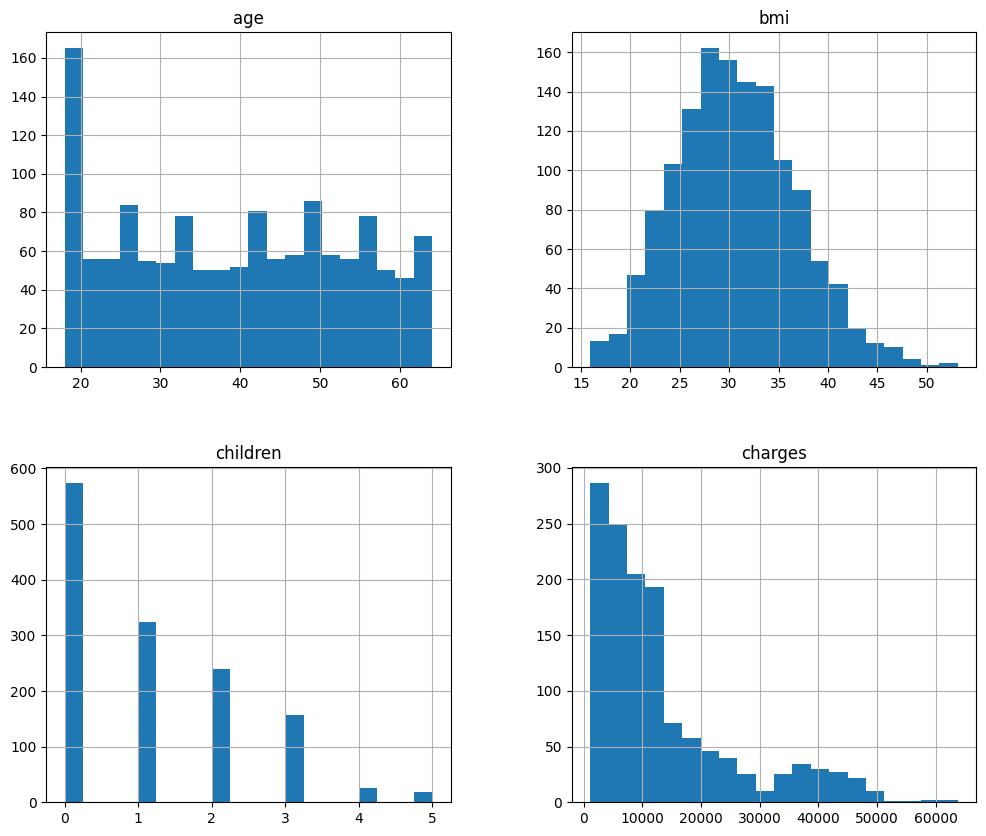

In [23]:
%matplotlib inline
df.hist(bins=20, figsize=(12, 10))


## Observation
1. We see that age distribution is the most spread out of all.
2. BMI somewhat follows a normal distribution.
3. Children column is a discrete numerical variable.
4. Less amount of charges is more frequent than high amount of charges.


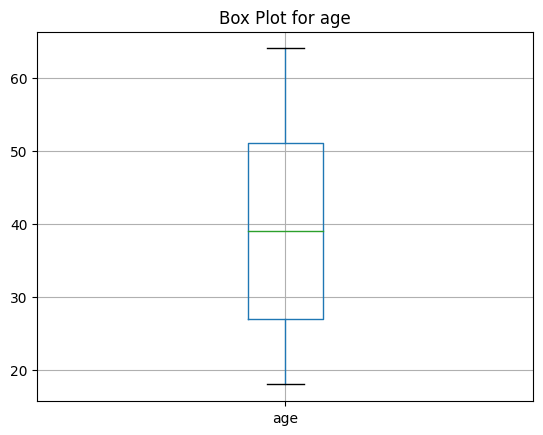

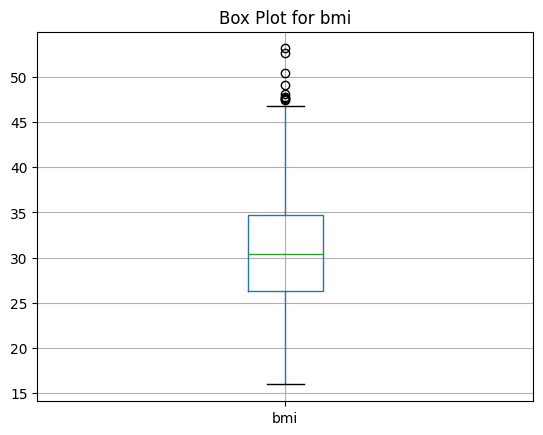

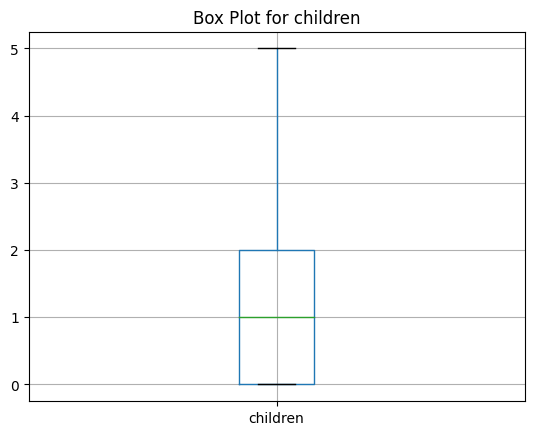

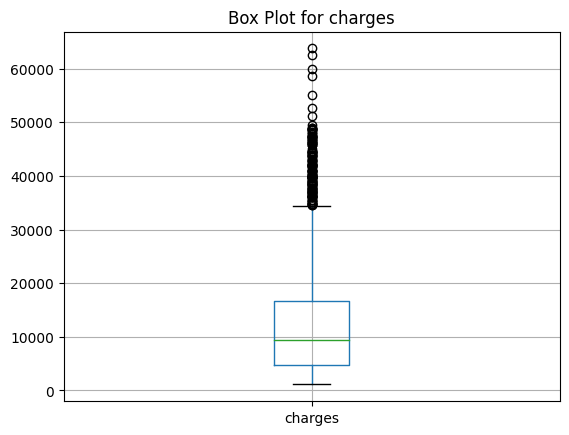

In [24]:
numeric_columns = df.select_dtypes(include=['number']).columns

for column in numeric_columns:
    df.boxplot(column=column)
    plt.title(f'Box Plot for {column}')
    plt.show()

## Observation

1. We see charges has a long upper tail with outliers.
2. BMI has outliers too but comparatively shorter upper tail.
3. Children and age have similar amount of variations.
4. Bmi and charges have similar amount of variations.

## Outlier removal

In [25]:
def remove_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return column[(column >= lower_bound) & (column <= upper_bound)]


for i, column in enumerate(numeric_columns):
    df[column] = remove_outliers(df[column])



## Boxplot of Smoker vs Non Smoker

Lets check out how smokers are charged vs non smokers.

<Axes: xlabel='smoker', ylabel='charges'>

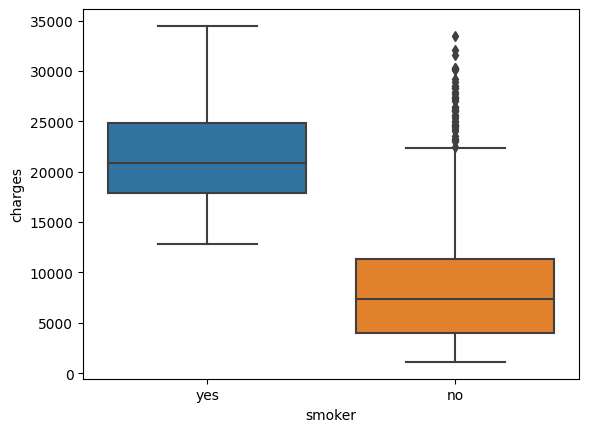

In [26]:
sns.boxplot(x='smoker', y='charges', data=df)

## Observation

1. Smokers are charged more than smokers. Hence, our hypothesis stands correct.
2. They both have similar amounts of varation.

## Boxplot of Male vs Female

<Axes: xlabel='sex', ylabel='charges'>

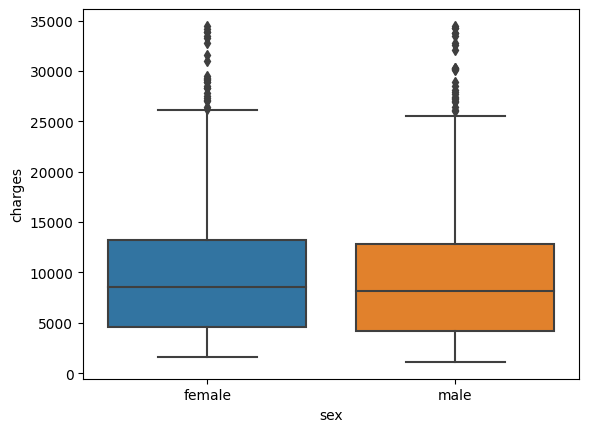

In [27]:
sns.boxplot(x='sex', y='charges', data=df)

## Observation

We do not see a significant difference in charges for male vs female. Therefore, our hypothesis stands corrected.

## Pairplot

Let us create a matrix of pairplot to observe any correlations.

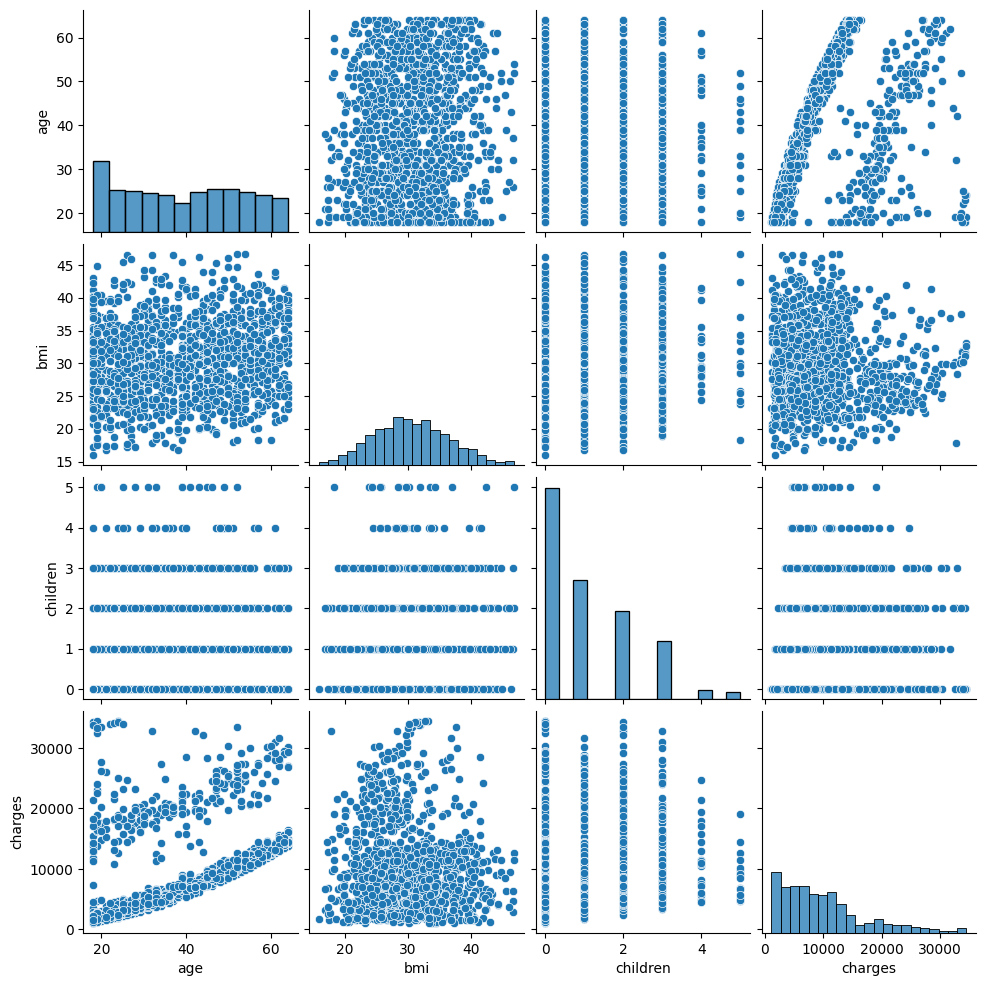

In [28]:
sns.pairplot(df[numeric_columns])

## Observation

1. We can see some positive correlation of charges with age.
2. Based on our assumption earlier, we fail to see any correlation between bmi and charges.
3. Children is a discrete variable and hence doesn't show any meaningful insights here.

## Pearson Correlations Matrix
Let's create compute a matrix of Pearson correlations to look at the coefficient of correlations.

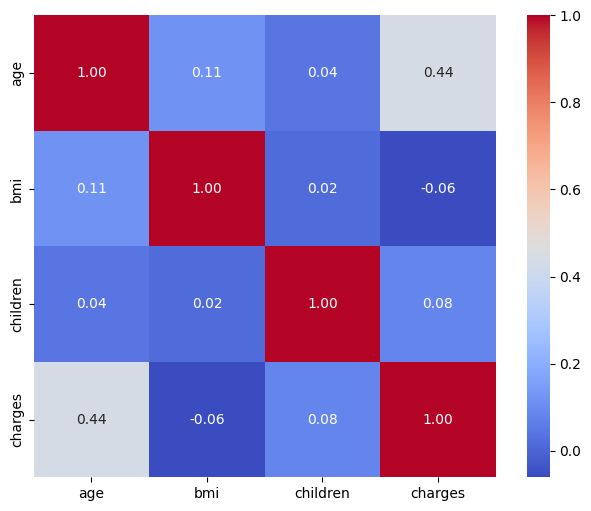

In [29]:
correlation_matrix = df[numeric_columns].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.show()

## Refined Hypothesis

1. There is a significant positive correlation between age and charges.
2. There is a weak positive correlation between children and charges and bmi and age.
3. There is no significant correlation between bmi and charges.
4. Smokers would have higher charges than non smokers.
5. The charges have no relation to the sex of the member.


## EDA Conclusions

1. Age would be a very good predictor for the charges.
2. Children should have some impact in predicting the charges.
3. Smoker column would have some impact on the charges.


# Part 2

We will apply regression on this dataset to predict the charges of insurance.

## Analysis to either normalize or standardize

Let's check the distribution of the columns by drawing histograms and kernel densities of the columns. We will drop the target variable since the distribution of the target variable will not affect our decision to standardize/normalize





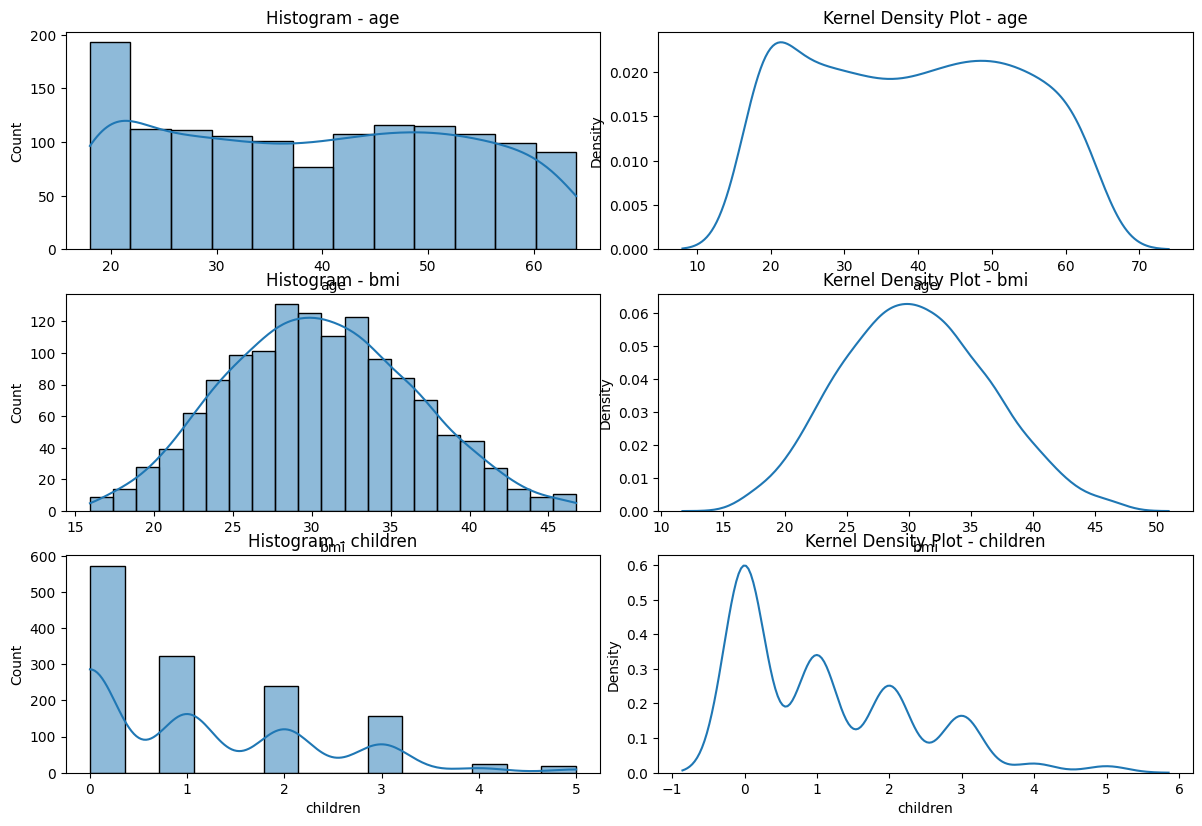

In [35]:
# Dropping the target variable
numeric_columns = numeric_columns[:-1]

fig, axes = plt.subplots(nrows=len(numeric_columns), ncols=2, figsize=(12, 8))
fig.tight_layout()

# Loop through numerical columns and create distribution plots
for i, column in enumerate(numeric_columns):
    # Histogram
    sns.histplot(df[column], kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Histogram - {column}')

    # Kernel Density Plot
    sns.kdeplot(df[column], ax=axes[i, 1])
    axes[i, 1].set_title(f'Kernel Density Plot - {column}')

plt.show()

## Observation

We can see that the predictor variables Age and Children do not follow a guassian distribution whereas BMI predictor variable does. Standardization is recommended when we do know the distribution of the predictor variables is guassian. Here, we know that BMI is the only one that follows a guassian distribution and hence, standardization wont be as effective.

Let's check the box plots again to see if there are outlier still present in our dataset

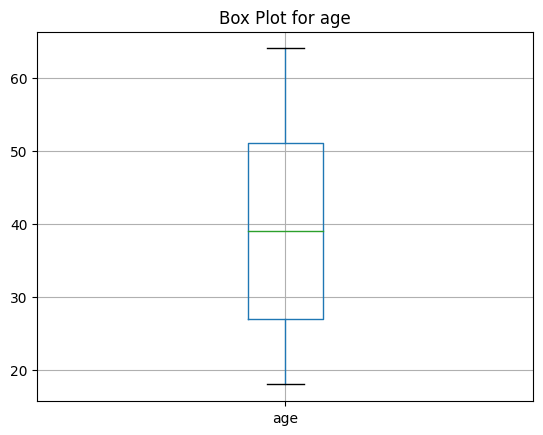

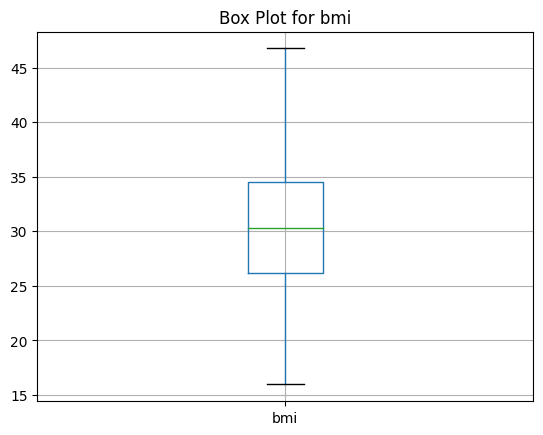

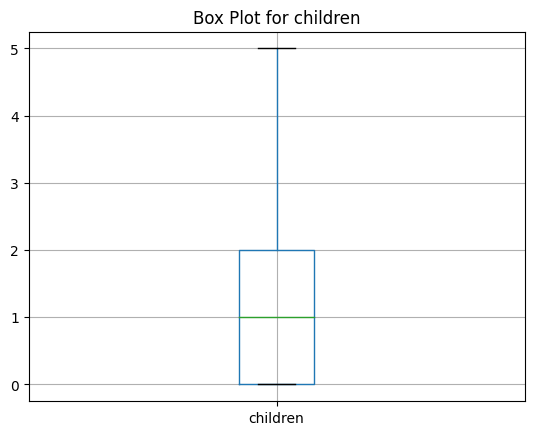

In [36]:
for column in numeric_columns:
    df.boxplot(column=column)
    plt.title(f'Box Plot for {column}')
    plt.show()

## Observation

We can see there are no outliers present in the predictor variables. Age and BMI have a slightly different scale whereas children has a much smaller scale. Hence, normalization will be an effective technique here to get better results.

## Normalizing the Data

We will use MinMaxScaler to normalize the predictor variables.

In [41]:
# Let's get the data in X (predictors) and y (target) variables
X = df[numeric_columns]
y = df['charges']

scaler = MinMaxScaler()

X_normalized = scaler.fit_transform(X)


X_normalized[:10]

array([[0.02173913, 0.38778824, 0.        ],
       [0.        , 0.57843456, 0.2       ],
       [0.2173913 , 0.55342644, 0.6       ],
       [0.32608696, 0.21906463, 0.        ],
       [0.30434783, 0.41961676, 0.        ],
       [0.2826087 , 0.3176356 , 0.        ],
       [0.60869565, 0.56771679, 0.2       ],
       [0.41304348, 0.38259175, 0.6       ],
       [0.41304348, 0.45047093, 0.4       ],
       [0.91304348, 0.3208834 , 0.        ]])